# Adversarial Search: Playing Connect 4

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Implement adversarial search algorithms for strategic game play.
* Analyze and optimize search in complex game spaces.
* Design effective heuristic evaluation functions.
* Compare performance across different agent strategies.
* Evaluate algorithmic trade-offs between decision quality and efficiency.

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file. 


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Describe each component and then implement it as a function that can be used by search algorithms.

In [9]:
# Task 1: Định nghĩa bài toán tìm kiếm cho Connect4
# Định nghĩa: trạng thái là một mảng numpy kích thước (rows, cols) chứa 0 (ô trống), 1 (player red) hoặc -1 (player yellow).
# Initial state: empty_board(rows, cols) trả về trạng thái ban đầu.
# Actions: một hành động là chỉ số cột (0..cols-1) nơi đặt đĩa; hành động hợp lệ nếu cột đó chưa đầy.
# Result(state, player, action): trả về bản sao của state sau khi player thả đĩa vào action.
# Terminal(state): kiểm tra xem có người thắng hoặc bảng đầy (hòa).
# Utility(state, player): trả về +1 nếu player thắng, -1 nếu thua, 0 nếu hòa hoặc không kết thúc.
import numpy as np
from typing import Tuple, List

def empty_board(rows: int = 6, cols: int = 7) -> np.ndarray:
    """Trả về bảng rỗng kích thước rows x cols (0 = empty).
    Thích hợp cho mọi kích thước bảng để thử nghiệm.
    """
    return np.zeros((rows, cols), dtype=int)

def initial_state(rows: int = 6, cols: int = 7) -> np.ndarray:
    """Alias cho empty_board để biểu diễn trạng thái khởi tạo.
    """
    return empty_board(rows, cols)

def valid_actions(state: np.ndarray) -> List[int]:
    """Trả về danh sách các cột (int) có thể đặt đĩa (chưa đầy).
    Duyệt theo cột: nếu ô trên cùng (row 0) == 0 => cột còn chỗ.
    """
    rows, cols = state.shape
    actions = [c for c in range(cols) if state[0, c] == 0]
    return actions

def result(state: np.ndarray, player: int, action: int) -> np.ndarray:
    """Trả về bản sao mới của state sau khi player thả đĩa vào cột action.
    Nếu action không hợp lệ, ném ValueError.
    """
    if action not in valid_actions(state):
        raise ValueError(f'Invalid action {action} for state')
    new_state = state.copy()
    rows, cols = state.shape
    # tìm hàng thấp nhất (lớn nhất index) có giá trị 0 trong cột action
    for r in range(rows-1, -1, -1):
        if new_state[r, action] == 0:
            new_state[r, action] = player
            break
    return new_state

def _check_four_in_a_row(arr: List[int], player: int) -> bool:
    """Helper: kiểm tra chuỗi con độ dài 4 của cùng màu trong list 1D.
    """
    count = 0
    for v in arr:
        if v == player:
            count += 1
            if count >= 4:
                return True
        else:
            count = 0
    return False

def terminal(state: np.ndarray) -> Tuple[bool, int]:
    """Trả về (is_terminal, winner).
    Nếu trò chơi đã kết thúc trả về (True, winner) với winner ∈ {1, -1, 0}.
    Nếu chưa kết thúc trả về (False, 0).
    """
    winner = 0  # 0 if no winner yet, 1 or -1 indicate player who won
    rows, cols = state.shape
    # kiểm tra hàng ngang
    for r in range(rows):
        if _check_four_in_a_row(list(state[r, :]), 1):
            return True, 1
        if _check_four_in_a_row(list(state[r, :]), -1):
            return True, -1
    # kiểm tra cột dọc
    for c in range(cols):
        col_vals = [state[r, c] for r in range(rows)]
        if _check_four_in_a_row(col_vals, 1):
            return True, 1
        if _check_four_in_a_row(col_vals, -1):
            return True, -1
    # kiểm tra đường chéo (
    # các đường chéo có thể được trích xuất bằng cách cố định (r0,c0) và đi xuống phải
    for r0 in range(rows):
        for c0 in range(cols):
            diag = []
            r, c = r0, c0
            while r < rows and c < cols:
                diag.append(state[r, c])
                r += 1
                c += 1
            if _check_four_in_a_row(diag, 1):
                return True, 1
            if _check_four_in_a_row(diag, -1):
                return True, -1
    # kiểm tra đường chéo (/)
    for r0 in range(rows):
        for c0 in range(cols):
            diag = []
            r, c = r0, c0
            while r < rows and c >= 0:
                diag.append(state[r, c])
                r += 1
                c -= 1
            if _check_four_in_a_row(diag, 1):
                return True, 1
            if _check_four_in_a_row(diag, -1):
                return True, -1
    # nếu bảng đầy thì kết thúc hòa
    if not any(state[0, c] == 0 for c in range(cols)):
        return True, 0
    return False, 0

def utility(state: np.ndarray, player: int) -> int:
    """Trả về utility từ quan điểm của player: +1 nếu player thắng, -1 nếu thua, 0 khác.
    """
    is_term, winner = terminal(state)
    if not is_term:
        return 0
    if winner == 0:
        return 0
    return 1 if winner == player else -1

How big is the state space? Give an estimate and explain it.

In [10]:
# Ước lượng kích thước không gian trạng thái cho Connect4:
# Với bảng 6x7, mỗi ô có thể là -1, 0 hoặc 1, nên trên lý thuyết là 3^(6*7) trạng thái,
# tức là 3^42 ≈ 1.5e20. Tuy nhiên nhiều trạng thái không thể xảy ra do tính chất rơi xuống của đĩa,
# và còn phải xét quy trình chơi (lượt đi). Thực tế không gian trạng thái khả thi nhỏ hơn nhiều nhưng vẫn rất lớn.
# Kết luận: trạng thái khả dĩ cực lớn (nghịch lý so với brute-force).
print('Estimate: ~3^(rows*cols) upper bound (3^42 for 6x7) but actual reachable states far fewer due to gravity constraints')

Estimate: ~3^(rows*cols) upper bound (3^42 for 6x7) but actual reachable states far fewer due to gravity constraints


How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [11]:
# Ước lượng kích thước cây trò chơi (game tree) cho minimax:
# Nếu coi branching factor trung bình ≈ b và độ sâu tối đa của trò chơi ≈ d (số ô tối đa),
# thì số node ~ b^d. Với bảng 6x7, b ≈ 7 lúc đầu và d ≤ 42, nên cây rất lớn (7^42 ≈ 1.6e35)
# Vì vậy cần cắt tỉa (alpha-beta) và/hoặc giới hạn độ sâu + heuristic để thực hiện được trong thời gian hợp lý.
print('Game-tree size approx b^d, e.g., 7^42 upper bound — infeasible for brute-force minimax')

Game-tree size approx b^d, e.g., 7^42 upper bound — infeasible for brute-force minimax


## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [12]:
import numpy as np
# Demo nhỏ: dùng hàm empty_board đã được định nghĩa ở trên (rows, cols).
# Tránh định nghĩa lại empty_board ở đây để không ghi đè signature mong muốn.
print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

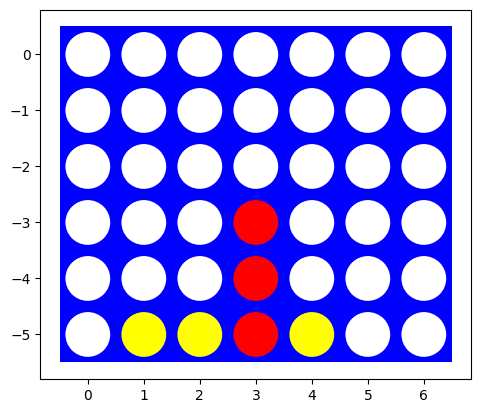

In [13]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [14]:
# Task 2: Helper functions và môi trường chơi cơ bản cho Connect4
# Bao gồm: actions(state), result(state,player,action) đã cài ở trên (nhưng ta có thể thêm một lớp môi trường đơn giản).
from typing import Callable, Tuple

class Connect4Env:
    """Môi trường Connect4 đơn giản để dùng trong thử nghiệm: lưu trạng thái, cho phép chơi một bước và kiểm tra kết thúc.
    """
    def __init__(self, rows: int = 6, cols: int = 7):
        self.rows = rows
        self.cols = cols
        self.state = empty_board(rows, cols)
        self.current_player = 1

    def reset(self) -> np.ndarray:
        self.state = empty_board(self.rows, self.cols)
        self.current_player = 1
        return self.state

    def step(self, action: int) -> Tuple[np.ndarray, int, bool, dict]:
        """Thực hiện action cho current_player, trả về (state, reward, done, info).
        Reward sử dụng hàm utility cho player vừa di chuyển.
        """
        if action not in valid_actions(self.state):
            raise ValueError('Invalid action')
        self.state = result(self.state, self.current_player, action)
        done, winner = terminal(self.state)
        reward = 0
        if done:
            if winner == 0:
                reward = 0
            else:
                reward = 1 if winner == self.current_player else -1
        info = {'winner': winner}
        # chuyển người chơi nếu trò chơi chưa kết thúc
        if not done:
            self.current_player *= -1
        return self.state, reward, done, info

    def legal_actions(self):
        return valid_actions(self.state)

# Hàm giúp chạy một trận giữa hai agent functions
def play_game(agent1: Callable, agent2: Callable, env: Connect4Env, verbose: bool = False) -> int:
    """Cho hai agent (agent(board, player)) chơi trên env; trả về winner (1, -1 or 0 for draw).
    Agent1 sẽ chơi player=1 (red) và agent2 chơi player=-1 (yellow).
    """
    env.reset()
    agents = {1: agent1, -1: agent2}
    while True:
        player = env.current_player
        board = env.state
        action = agents[player](board.copy(), player=player)
        state, reward, done, info = env.step(action)
        if verbose:
            print(f'Player {player} -> action {action}, reward={reward}, done={done}')
        if done:
            return info.get('winner', 0)

# Random agent implementation (signature required)
import random
def random_player(board: np.ndarray, player: int = 1) -> int:
    """Agent ngẫu nhiên: chọn một hành động hợp lệ ngẫu nhiên.
    - board: numpy array trạng thái hiện tại
    - player: 1 hoặc -1
    Trả về: chỉ số cột (int) để đặt đĩa.
    """
    actions = valid_actions(board)
    if not actions:
        raise ValueError('No legal actions available')
    return random.choice(actions)

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [15]:
# Ví dụ: cho 2 agent ngẫu nhiên chơi 1000 ván và đếm kết quả.
def tournament_random_vs_random(n_games: int = 1000, rows: int = 6, cols: int = 7):
    env = Connect4Env(rows, cols)
    results = {1: 0, -1: 0, 0: 0}
    for i in range(n_games):
        winner = play_game(random_player, random_player, env, verbose=False)
        results[winner] += 1
    return results

# Nếu bạn muốn chạy nhanh thử nghiệm nhỏ:
# print(tournament_random_vs_random(100))

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [16]:
# Chạy giải đấu 1000 trận giữa hai agent ngẫu nhiên (Task 2 experiment).
# Lưu ý: tùy vào hiệu năng, bạn có thể giảm số trận để chạy nhanh.
results = tournament_random_vs_random(1000)
print('Kết quả sau 1000 ván (1, -1, 0):', results)

Kết quả sau 1000 ván (1, -1, 0): {1: 561, -1: 435, 0: 4}


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points] 

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__ 
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [ ]:
# Task 3: Minimax search with Alpha-Beta pruning
# Implement minimax/alpha-beta as một hàm quyết định (minimax_decision) và một lớp agent lưu trạng thái để gọi như agent(board, player).
import time
from typing import Optional, Callable, List

def minimax_decision(board: np.ndarray, player: int, max_depth: Optional[int] = None, order_actions_fn: Optional[Callable] = None, eval_fn: Optional[Callable] = None) -> int:
    """Trả về hành động tốt nhất cho player bằng Minimax + Alpha-Beta.
    - board: numpy array trạng thái hiện tại
    - player: người đang đi (1 hoặc -1)
    - max_depth: nếu không None thì cắt ở độ sâu đó (depth tính theo số lượt từ root, root depth=0)
    - order_actions_fn: hàm tùy chọn để sắp xếp hành động nhằm cải thiện pruning
    - eval_fn: hàm heuristic(state, player) được gọi khi cắt (cutoff)
    """
    nodes = 0
    def max_value(state, alpha, beta, depth):
        nonlocal nodes
        nodes += 1
        is_term, winner = terminal(state)
        if is_term:
            return utility(state, player)
        if max_depth is not None and depth >= max_depth:
            return eval_fn(state, player) if eval_fn is not None else utility(state, player)
        v = -float('inf')
        actions = valid_actions(state)
        if order_actions_fn is not None:
            actions = order_actions_fn(state, player, actions)
        for a in actions:
            v = max(v, min_value(result(state, player, a), alpha, beta, depth+1))
            alpha = max(alpha, v)
            if alpha >= beta:
                break
        return v

    def min_value(state, alpha, beta, depth):
        nonlocal nodes
        nodes += 1
        is_term, winner = terminal(state)
        if is_term:
            return utility(state, player)
        if max_depth is not None and depth >= max_depth:
            return eval_fn(state, -player) if eval_fn is not None else utility(state, player)
        v = float('inf')
        actions = valid_actions(state)
        if order_actions_fn is not None:
            actions = order_actions_fn(state, -player, actions)
        for a in actions:
            v = min(v, max_value(result(state, -player, a), alpha, beta, depth+1))
            beta = min(beta, v)
            if alpha >= beta:
                break
        return v

    best_action = None
    best_val = -float('inf')
    start = time.perf_counter()
    actions = valid_actions(board)
    if order_actions_fn is not None:
        actions = order_actions_fn(board, player, actions)
    for a in actions:
        v = min_value(result(board, player, a), -float('inf'), float('inf'), 1)
        if v > best_val:
            best_val = v
            best_action = a
    elapsed = time.perf_counter() - start
    return best_action

class MinimaxAgent:
    """Agent dựa trên Minimax + Alpha-Beta. Có thể cấu hình độ sâu cắt, strategy sắp xếp hành động và heuristic eval_fn.
    Gọi như: agent(board, player) để phù hợp với môi trường.
    """
    def __init__(self, max_depth: Optional[int] = None, order_actions_fn: Optional[Callable] = None, eval_fn: Optional[Callable] = None):
        self.max_depth = max_depth
        self.order_actions_fn = order_actions_fn
        self.eval_fn = eval_fn

    def __call__(self, board: np.ndarray, player: int = 1) -> int:
        return minimax_decision(board, player, max_depth=self.max_depth, order_actions_fn=self.order_actions_fn, eval_fn=self.eval_fn)

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

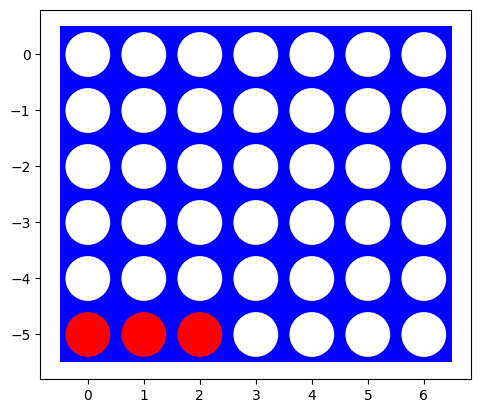

Minimax chọn cột: 3


In [18]:
# Task 3 experiments: kiểm tra một vài board mẫu để xem agent có phát hiện nước thắng ngay lập tức hay không.
# Tạo board mẫu: ví dụ một board nơi player=1 có thể thắng bằng cách thả vào cột cụ thể.
# Lưu ý: index cột bắt đầu từ 0.
# Board mẫu: 6x7 với vài quân đã nằm sẵn
board = empty_board(6,7)
# đặt một tình huống nơi player 1 có 3 nối và cần 1 để thắng ngang
board[5,0] = 1
board[5,1] = 1
board[5,2] = 1
# bảo đảm cột 3 trống ở đáy để thắng
visualize(board)
agent = MinimaxAgent(max_depth=4)  # depth nhỏ ban đầu để chạy nhanh
best = agent(board, player=1)
print('Minimax chọn cột:', best)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board is not feasible.

In [19]:
# Move ordering và đo thời gian thực hiện nước đi
import time

def center_first_order(state, player, actions):
    # ưu tiên các cột gần giữa bảng (thường tốt cho Connect4)
    cols = state.shape[1]
    center = (cols - 1) / 2.0
    return sorted(actions, key=lambda a: abs(a - center))

def time_agent_move(agent_fn, board, player=1):
    start = time.perf_counter()
    a = agent_fn(board, player=player)
    elapsed = time.perf_counter() - start
    return a, elapsed

# Tạo board phức tạp hơn để thử nghiệm thời gian
test_board = empty_board(6,7)
# làm đầy một vài cột để tăng branching
for c in [0,1,2,4,5]:
    for r in range(3):
        test_board[5-r, c] = 1 if r % 2 == 0 else -1

# Agent không dùng ordering
agent_plain = MinimaxAgent(max_depth=4, order_actions_fn=None)
a1, t1 = time_agent_move(agent_plain, test_board, player=1)
# Agent dùng ordering trung tâm
agent_ordered = MinimaxAgent(max_depth=4, order_actions_fn=center_first_order)
a2, t2 = time_agent_move(agent_ordered, test_board, player=1)
print('plain:', a1, 'time:', t1)
print('ordered:', a2, 'time:', t2)

plain: 1 time: 0.11823850002838299
ordered: 3 time: 0.019431900000199676


### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [20]:
# Move-ordering: so sánh thời gian thực thi với/không có ordering trên các độ sâu khác nhau
import time
def measure_ordering(board, player, depths=(2,3,4)):
    results = []
    for d in depths:
        a_plain, t_plain = None, None
        a_ord, t_ord = None, None
        agent_plain = MinimaxAgent(max_depth=d, order_actions_fn=None)
        agent_ord = MinimaxAgent(max_depth=d, order_actions_fn=center_first_order)
        start = time.perf_counter(); a_plain = agent_plain(board, player=player); t_plain = time.perf_counter()-start
        start = time.perf_counter(); a_ord = agent_ord(board, player=player); t_ord = time.perf_counter()-start
        results.append((d, t_plain, t_ord))
    return results

# Thử trên một board thử nghiệm (đã tạo ở ô trước là test_board)
res = measure_ordering(test_board, player=1, depths=(2,3))
print('depth, time_plain, time_ordered')
for row in res:
    print(row)

depth, time_plain, time_ordered
(2, 0.01076380000449717, 0.009926199971232563)
(3, 0.034808100026566535, 0.015500899986363947)


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [21]:
# The first few moves: đề xuất chính sách mở đầu đơn giản và hiện thực hóa nó.
# Gợi ý: ở Connect4, các cột giữa thường mạnh hơn; ta có thể dùng heuristic opening: chọn cột giữa nếu có thể.
def opening_policy(board: np.ndarray, player: int = 1) -> int:
    cols = board.shape[1]
    center = cols // 2
    actions = valid_actions(board)
    if center in actions:
        return center
    # nếu không có giữa, chọn cột gần giữa nhất
    actions_sorted = sorted(actions, key=lambda a: abs(a - center))
    return actions_sorted[0]

# Ví dụ: mở đầu trên bảng rỗng 6x7
b = empty_board(6,7)
print('Opening pick (center-preference):', opening_policy(b, player=1))

Opening pick (center-preference): 3


### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [22]:
# Playtime: cho Minimax (depth-limited) chơi với Random trên board nhỏ 4x4
def play_minimax_vs_random(n_games: int = 10, rows: int = 4, cols: int = 4, depth: int = 4):
    env = Connect4Env(rows, cols)
    mm_agent = MinimaxAgent(max_depth=depth, order_actions_fn=None)
    results = {1: 0, -1: 0, 0: 0}
    for i in range(n_games):
        winner = play_game(mm_agent, random_player, env, verbose=False)
        results[winner] += 1
    return results

print(play_minimax_vs_random(10, 4, 4, depth=4))

{1: 8, -1: 0, 0: 2}


## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [23]:
# Task 4: Heuristic evaluation function (window-based, stronger)
def heuristic_eval(state: np.ndarray, player: int) -> float:
    """Window-based heuristic: quét mọi cửa sổ độ dài 4 (hàng, cột, 2 đường chéo).
    Trả điểm cho patterns: 4-in-row (very large), open-3, closed-3, open-2; cộng bonus trung tâm.
    Kết quả chuẩn hóa về [-1,1].
    """
    rows, cols = state.shape
    def windows_of_length_4(s):
        # rows
        for r in range(rows):
            for c in range(cols - 4 + 1):
                yield [s[r, c+i] for i in range(4)]
        # cols
        for c in range(cols):
            for r in range(rows - 4 + 1):
                yield [s[r+i, c] for i in range(4)]
        # diag \ (down-right)
        for r in range(rows - 4 + 1):
            for c in range(cols - 4 + 1):
                yield [s[r+i, c+i] for i in range(4)]
        # anti-diag / (down-left)
        for r in range(rows - 4 + 1):
            for c in range(3, cols):
                yield [s[r+i, c-i] for i in range(4)]
    # weights
    W4 = 1000.0
    W_open3 = 50.0
    W_3 = 10.0
    W_open2 = 3.0
    W_center = 1.0
    score = 0.0
    def eval_window(win, p):
        cnt_p = sum(1 for x in win if x == p)
        cnt_opp = sum(1 for x in win if x == -p)
        if cnt_p == 4: return W4
        if cnt_opp == 4: return -W4
        if cnt_p == 3 and cnt_opp == 0: return W_open3
        if cnt_opp == 3 and cnt_p == 0: return -W_open3
        if cnt_p == 2 and cnt_opp == 0: return W_open2
        if cnt_opp == 2 and cnt_p == 0: return -W_open2
        return 0.0
    for win in windows_of_length_4(state):
        score += eval_window(win, player)
    # center control bonus
    center_col = cols // 2
    for r in range(rows):
        if state[r, center_col] == player: score += W_center
        elif state[r, center_col] == -player: score -= W_center
    # normalize
    approx_max = W4 + (W_open3 * 10) + (W_open2 * 20) + (W_center * rows)
    val = max(-1.0, min(1.0, score / approx_max))
    return val

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [24]:
# Cutting off search: sử dụng minimax_decision với eval_fn (không dùng monkey-patch)
def minimax_with_cutoff(board: np.ndarray, player: int, cutoff_depth: int, order_actions_fn: Optional[Callable]=None) -> int:
    """Wrapper: gọi minimax_decision với eval_fn=heuristic_eval để cắt ở cutoff_depth.
    Trả về action (int).
    """
    return minimax_decision(board, player, max_depth=cutoff_depth, order_actions_fn=order_actions_fn, eval_fn=heuristic_eval)

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [25]:
# Task 4 experiment: kiểm tra heuristic trên các board mẫu (tức là xem heuristic đánh giá như thế nào)
samples = []
# sample 1: center occupied by player 1
s1 = empty_board(6,7)
s1[5,3] = 1
samples.append(('center', s1))
# sample 2: near-win for player 1 horizontally
s2 = empty_board(6,7)
s2[5,0]=1; s2[5,1]=1; s2[5,2]=1
samples.append(('h-almost', s2))
for name, b in samples:
    print(name, 'heuristic for player 1:', heuristic_eval(b, 1))

center heuristic for player 1: 0.0006385696040868455
h-almost heuristic for player 1: 0.03384418901660281


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [26]:
# Task 4 timing: đo thời gian thực hiện nước đi trên các kích thước bảng khác nhau với cutoff depth cố định
import time
def measure_time_for_size(rows, cols, depth=4):
    env = Connect4Env(rows, cols)
    b = empty_board(rows, cols)
    agent = MinimaxAgent(max_depth=depth, eval_fn=heuristic_eval)
    start = time.perf_counter()
    a = agent(b, player=1)
    return time.perf_counter()-start
for size in [(4,4),(5,5),(6,7)]:
    t = measure_time_for_size(size[0], size[1], depth=3)
    print('size', size, 'time', t)

size (4, 4) time 0.004078500031027943
size (5, 5) time 0.011872900009620935
size (6, 7) time 0.04363440000452101


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [27]:
# Let two heuristic search agents (different cutoff depth) play once on a 6x7 board
env = Connect4Env(6,7)
agent_deep = MinimaxAgent(max_depth=4, eval_fn=heuristic_eval)
agent_shallow = MinimaxAgent(max_depth=2, eval_fn=heuristic_eval)
winner = play_game(agent_deep, agent_shallow, env, verbose=False)
print('Winner (deep vs shallow):', winner)

Winner (deep vs shallow): 1


## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [28]:
# Pure Monte Carlo Search (graduate bonus):
import random

def rollout_random(b, player):
    """Thực hiện một rollout ngẫu nhiên từ trạng thái b; trả về winner."""
    env = Connect4Env(b.shape[0], b.shape[1])
    env.state = b.copy()
    env.current_player = player
    while True:
        actions = env.legal_actions()
        if not actions:
            # no legal actions -> draw
            return 0
        a = random.choice(actions)
        state, reward, done, info = env.step(a)
        if done:
            return info.get('winner', 0)
    # fallback (shouldn't reach)
    return 0

def pure_monte_carlo(b, player, n_trials=200):
    # trả về action có tỉ lệ thắng cao nhất khi thực hiện n_trials rollout cho mỗi action
    actions = valid_actions(b)
    if not actions:
        return None
    scores = {a: 0 for a in actions}
    for a in actions:
        for t in range(n_trials):
            newb = result(b, player, a)
            winner = rollout_random(newb, -player)
            if winner == player:
                scores[a] += 1
    # pick argmax (break ties randomly)
    max_score = max(scores.values())
    best_actions = [a for a, s in scores.items() if s == max_score]
    return random.choice(best_actions)

# quick test on a small board:
b = empty_board(4,4)
print('PureMC pick:', pure_monte_carlo(b, 1, n_trials=50))

PureMC pick: 2


### Best First Move

Use your Monte Carlo Search to determine what the best first move for red is? Describe under what assumptions this is the "best" first move.  

In [29]:
# Best First Move using Monte Carlo: chạy pure_monte_carlo cho board rỗng và thống kê các lựa chọn
b = empty_board(6,7)
best_move = pure_monte_carlo(b, 1, n_trials=200)
print('Best first move by Pure Monte Carlo (approx):', best_move)
# Lưu ý: kết quả phụ thuộc vào số trials; nhiều trials -> ổn định hơn.

Best first move by Pure Monte Carlo (approx): 3
